In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Format set
gender = pd.read_csv('gender_submission.csv')

# Our main dataset
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

# Exploratory Data Analysis
#### Titanic Data Set Variables

| Variable | Definition                           | Key                                       |
|----------|--------------------------------------|-------------------------------------------|
| survival | Survival                             | 0 = No, 1 = Yes                           |
| pclass   | Ticket class                         | 1 = 1st, 2 = 2nd, 3 = 3rd                 |
| sex      | Sex                                  |                                           |
| Age      | Age in years                         |                                           |
| sibsp    | # of siblings / spouses aboard the Titanic |                                           |
| parch    | # of parents / children aboard the Titanic |                                           |
| ticket   | Ticket number                        |                                           |
| fare     | Passenger fare                       |                                           |
| cabin    | Cabin number                         |                                           |
| embarked | Port of Embarkation                  | C = Cherbourg, Q = Queenstown, S = Southampton |



Given the presence of an indexed indicator column 'PassengerId' with no NA values, this is a clear choice to index our data. Data such as 'Name' is not relevant, unless one does natural language processing to categorize names according to some predetermined origin. Sex is easily manipulated to be binary, and can be used as is with other binary variables such as 'SibSp' and 'Parch'. The 'Ticket' variable is not particularly useful with the presence of 'PassengerId' for indexing and will be removed. Similarly, the 'Cabin' variable is mostly NaN and can be removed for simplicity. The 'Embarked' data will be one-hot-encoded for binary usage in the model. From the initial interpretation of the data and the question at hand, it would seem that the 'Fare' and 'PClass' variables are to be a major driver in the prediction of survival.


In [ ]:
test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


#### Dropping Features

Not every column is going to be useful for predictive modeling. Some columns could be useful with enough manipulation but don't provide enough predictive power to the model to be worth adding. Here, the 'Name', 'Ticket', and 'Cabin' columns do not provide enough usable data without extreme amounts of manipulation. These columns can also be removed logically, as a person's name likely had little to do with their survival on the Titanic.

In [ ]:
# Dropping unnessicary features

nan_counts = test.isnull().sum()
# Compare the columns with NaN values
for column, count in nan_counts.iteritems():
    if count > 0:
        print(f"Column '{column}' has {count} NaN values.")


# for test set
test = test.drop('Name', axis = 1)
test = test.drop('Ticket', axis = 1)
test = test.drop('Cabin', axis = 1)

# for train set
train = train.drop('Name', axis = 1)
train = train.drop('Ticket', axis = 1)
train = train.drop('Cabin', axis = 1)

train

Column 'Age' has 86 NaN values.
Column 'Fare' has 1 NaN values.
Column 'Cabin' has 327 NaN values.


<ipython-input-167-9d72b6151ccc>:5: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, count in nan_counts.iteritems():


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...,...
886,887,0,2,male,27.0,0,0,13.0000,S
887,888,1,1,female,19.0,0,0,30.0000,S
888,889,0,3,female,NaN,1,2,23.4500,S
889,890,1,1,male,26.0,0,0,30.0000,C


#### Dropping NaN Rows and Data Interpolation

Now that we have solidified the data that we will be using, we will begin to make that data useful for our purposes. Simply dropping NaN values can lead to massive amounts of lost data. We can see below that if we were to simply drop all the NaN columns, we would lose 86 rows due just to age alone when age can be very easily manipulated such that we do lose that data. First, we will check to see what the age column looks like. In our set, the histogram of the age data is skewed, which makes sense for something like a cruise. We cannot simply use the mean here and instead will substitute it with the median. Mode imputation is another choice here, however, frequent ages may not be consistent with the trends in the data, and we will stick with a median. Given the nature of this challenge, we must produce 418 rows, and thus cannot drop any rows in this set. The only other NAN value here is 'Fare' which is also easily interpolated with median.


<ipython-input-168-44e5c9497460>:7: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, count in nan_counts.iteritems():


PassengerId     0
Pclass          0
Sex             0
Age            86
SibSp           0
Parch           0
Fare            1
Embarked        0
dtype: int64
Column 'Age' has 86 NaN values.
Column 'Fare' has 1 NaN values.
PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64


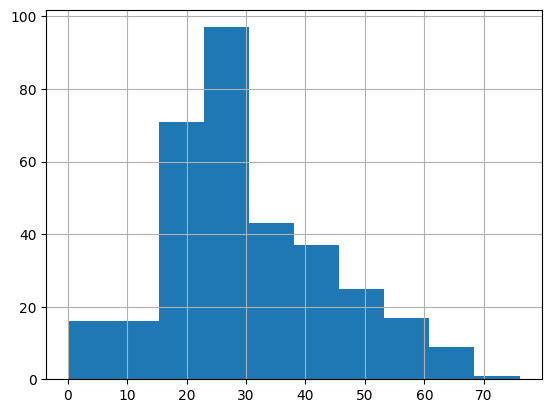

In [ ]:
# Comparing NaN values in the training set

nan_counts = test.isnull().sum()
print(nan_counts)

# Compare the columns with NaN values
for column, count in nan_counts.iteritems():
    if count > 0:
        print(f"Column '{column}' has {count} NaN values.")

# Histogram of age data
test['Age'].hist()

# Median Imputation
test['Age'].fillna(test['Age'].median(), inplace=True)
train['Age'].fillna(test['Age'].median(), inplace=True)

# Median Imputation for fare
test['Fare'].fillna(test['Fare'].median(), inplace=True)
train['Fare'].fillna(test['Fare'].median(), inplace=True)

# We now drop all other rows, as the only one containing a NaN value is 'Fare'
test = test.dropna()
train = train.dropna()


nan_counts = test.isnull().sum()
print(nan_counts)


#### Feature Types and Normalization

This dataset is relatively clean in this aspect. There is not a whole lot of converting that needs to be done for integer and float objects. For the 'Sex' object, however, we can apply binary mapping to male and female, as this set contains no deviation from those two types.


In [ ]:
print(train.dtypes)

# Translation of gender to binary

# for test set
test['Sex'] = test['Sex'].map({'female': 1, 'male': 0})

# for train set
train['Sex'] = train['Sex'].map({'female': 1, 'male': 0})

train['Sex'] = train['Sex'].astype('int')

print(train.dtypes)

PassengerId      int64
Survived         int64
Pclass           int64
Sex             object
Age            float64
SibSp            int64
Parch            int64
Fare           float64
Embarked        object
dtype: object
PassengerId      int64
Survived         int64
Pclass           int64
Sex              int64
Age            float64
SibSp            int64
Parch            int64
Fare           float64
Embarked        object
dtype: object


<ipython-input-169-5c1db2c5dff9>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Sex'] = train['Sex'].map({'female': 1, 'male': 0})
<ipython-input-169-5c1db2c5dff9>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Sex'] = train['Sex'].astype('int')


#### One-Hot-Encoding Embarked

Lastly, our embarked column is unusable as is. We need to manipulate it into a binary column such that it can be usable for prediction.

In [ ]:
# for test set
test = pd.get_dummies(test, columns=['Embarked'], dtype=int)

# for train set
train = pd.get_dummies(train, columns=['Embarked'], dtype=int)


#### Model Selection and Testing/Training

Here we use a Random Forest Classification model for high accuracy and predictive power. Other classification models could be used here, however for a binary outcome of survived or did'nt survive, the Random Forest Classification is extremely effective.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import cross_val_score


# Feature set
X = train.drop('Survived', axis = 1)

# Responding variable
y = train['Survived']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# note that there is no added accuracy from above 150 trees
clf = RandomForestClassifier(n_estimators= 150, random_state=42)

# Train the model on the training data
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

# Using cross validation, we can see how our model preforms on unknown data
scores = cross_val_score(clf, X, y, cv=5)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

print("Accuracy:", accuracy_score(y_test, y_pred))

# Random Forest Classification model for the entirety of the set




Accuracy: 0.80 (+/- 0.11)
Accuracy: 0.797752808988764


In [ ]:
titanic_forest = RandomForestClassifier(n_estimators = 150, random_state = 42)
titanic_forest.fit(X, y)


y_final = clf.predict(test)

predictions_df = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Survived': y_final
})

predictions_df.to_csv('jaeckl_titanic_predictions.csv', index=False)





from google.colab import files

files.download('jaeckl_titanic_predictions.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Our Final Predictions

In [ ]:
predictions_df

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
